In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime

import QuantLib as ql
from scipy.optimize import minimize

dataframe = "SPX"

# NASDAQ

df = pd.DataFrame()
if dataframe != "SPX":

    df = pd.read_csv(r'Nasdaq_optionChain_100821_1915.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')
    df["IV"] = df["IV"]/100
    df["IV (P)"] = df["IV (P)"]/100

    # Remove strikes from Dataframe
    fltr = [140., 145., 150., 155., 160., 165., 170., 175., 180., 185., 190., 195., 200., 210., 220.]
    df = df[df['Strike'].isin(fltr)]
else:
    df = pd.read_csv(r'spx_SABR.csv')
    df['Date'] = pd.to_datetime(df['Date'], format='%y%m%d')

    # Remove IV=0 strikes from Dataframe
    fltr = df[df["IV"] <= 0.]["Strike"].unique()
    df = df[~df['Strike'].isin(fltr)]
    df = df[~(df['Strike'] <= 3000)]

maturities = df["Date"].unique()
strikes = df["Strike"].unique()

today = ql.Date(10, 8, 2021) if dataframe != "SPX" else ql.Date(3, 8, 2021)
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()

current_time = pd.Timestamp(year=2021, month=8, day=10, hour=19) if dataframe != "SPX" else pd.Timestamp(year=2021, month=8, day=3, hour=12)
current_price = 188.68 if dataframe != "SPX" else 4300.

spot_quote = ql.QuoteHandle(ql.SimpleQuote(current_price))

rate = -.3
riskFreeCurve = ql.FlatForward(today, rate, ql.Actual365Fixed())
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(riskFreeCurve)

POW = 10**-2 if dataframe != "SPX" else 1
vols = [np.array(df[df["Date"] == maturities[m]]["IV"]* POW) for m in range(len(maturities))]


def delta_t(m):

    dt = m - today

    return round(dt/365, 6)

def date_pd_to_ql(date):
    date = pd.to_datetime(date)
    day = date.day
    month = date.month
    year = date.year

    return ql.Date(day, month, year)

dates = [date_pd_to_ql(d) for d in maturities]


In [20]:
#PLOTTING

#Plot volatility Surface
def plot_vol_surface(vol_surface, plot_years=np.arange(0.1, 1.4465753424657535, 0.1), plot_strikes=strikes, funct='blackVol'):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    fig = plt.figure(figsize=(20, 8))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Maturities')
    ax.set_zlabel('Implied Volatility')
    X, Y = np.meshgrid(plot_strikes, plot_years)

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                          for x, y in zip(xr,yr) ]
                     ).reshape(len(X), len(X[0]))

        surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, linewidth=0.3)

def plot_smile(date, smiles, market=True, title=""):

    market_vols = vols[dates.index(date)]

    fig, ax = plt.subplots(figsize=(25, 5))
    for smile in smiles:
        ax.plot(strikes, smile[0], label=smile[1])
    if market:
        ax.plot(strikes, market_vols, "rX", label="Actual")
        ax.plot([190.], market_vols[10], "o", label="ATM")
    ax.set_title(title)
    ax.set_xlabel("Strikes", size=12)
    ax.set_ylabel("Vols", size=12)
    legend = ax.legend(loc="upper right")


C:\Users\somig\AppData\Local\Temp/ipykernel_3164/1485649620.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


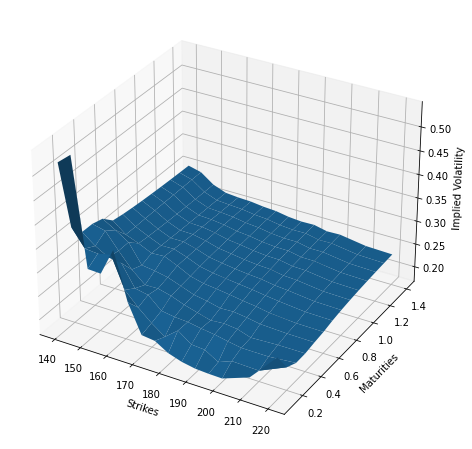

In [21]:
# BLACK VOLATILITY SURFACE

volMatrix = ql.Matrix(len(vols[0]), len(vols))

for i in range(len(vols)):
    for j in range(len(vols[i])):
        volMatrix[j][i] = vols[i][j]

black_var_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, volMatrix, day_count)
black_var_surface.enableExtrapolation()

plot_vol_surface(vol_surface=black_var_surface, plot_strikes=strikes, funct='blackVol')

In [22]:
#CALIBRATE VOLATILITY SURFACE

def volatilitySmileSABR(date, shift=0, beta=1, method="normal", fwd=current_price):

    expiryTime = delta_t(date)
    marketVols = vols[dates.index(date)]

    def set_beta():
        return beta
    
    def set_init_conds ():
        if beta >= .5:
            return [.1, set_beta(), .1, .1]
        else:
            return [.5, set_beta(), .4, -.9]

    def vols_by_method(strike, fwd, expiryTime, alpha, beta, nu, rho, shift):
        if method == "floch-kennedy":
            return ql.sabrFlochKennedyVolatility(strike + shift, fwd + shift, expiryTime, alpha, beta, nu, rho)
        else:
            return ql.sabrVolatility(strike + shift, fwd + shift, expiryTime, alpha, beta, nu, rho)

    def f(params):

        alpha, beta, nu, rho = params

        alpha = max(alpha, 1e-8) # Avoid alpha going negative
        beta = set_beta()
        nu = max(nu, 1e-8) # Avoid nu going negative
        rho = max(rho, -0.999) # Avoid rhp going < -1.0
        rho = min(rho, 0.999) # Avoid rho going > 1.0

        vols = np.array([
        vols_by_method(strike, fwd, expiryTime, alpha, beta, nu, rho, shift)
        for strike in strikes
        ])

        error = ((vols - np.array(marketVols))**2 ).mean() **.5

        return error

    cons = (
    {'type': 'ineq', 'fun': lambda x: x[0]},
    # {'type': 'ineq', 'fun': lambda x: 0.99 - x[1]},
    # {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]},
    {'type': 'ineq', 'fun': lambda x: .99 - x[3]**2}
    )

    x = set_init_conds()

    result = minimize(f, x, constraints=cons, method="SLSQP")
    error = result['fun']
    [alpha, beta, nu, rho] = result['x']

    newVols = [vols_by_method(strike, fwd, expiryTime, alpha, beta, nu, rho, shift) for strike in strikes]
    
    return dict(vols=newVols, error=error, params={"alpha": alpha, "beta": beta, "nu": nu, "rho": rho})

def volatilitySurfaceSABR(method="normal", beta=1, shift=0, fwd=current_price):

    vol_surface_vector, errors, _alpha, _beta, _nu, _rho = [], [], [], [], [], []
    SABRVolMatrix = ql.Matrix(len(strikes), len(dates))
    
    for i, d in enumerate(dates):
        volSABR = volatilitySmileSABR(date=d, beta=beta, shift=shift, method=method, fwd=fwd)

        _alpha.append(volSABR["params"]["alpha"])
        _beta.append(volSABR["params"]["beta"])
        _nu.append(volSABR["params"]["nu"])
        _rho.append(volSABR["params"]["rho"])
        
        errors.append(volSABR["error"])

        smile = volSABR["vols"]
        vol_surface_vector.extend(smile)

        #constructing the SABRVolatilityMatrix
        for j in range(len(smile)):
            SABRVolMatrix[j][i] = smile[j]
            
    return dict(vols=vol_surface_vector, volMatrix=SABRVolMatrix, e=errors, a=_alpha, b=_beta, n=_nu, r=_rho)


C:\Users\somig\AppData\Local\Temp/ipykernel_3164/1485649620.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


,alpha,beta,nu,rho
2021-08-20,0.136906,1.0,13.002911,-0.994987
2021-09-17,0.136848,1.0,3.681509,-0.232243
2021-10-15,0.169243,1.0,2.263193,-0.277232
2021-11-19,0.195223,1.0,1.619780,-0.304001
2021-12-17,0.197674,1.0,1.445803,-0.310927
2022-01-21,0.195368,1.0,1.519624,-0.258073
2022-03-18,0.220948,1.0,0.980765,-0.361758
2023-01-20,0.237486,1.0,0.703659,-0.278507


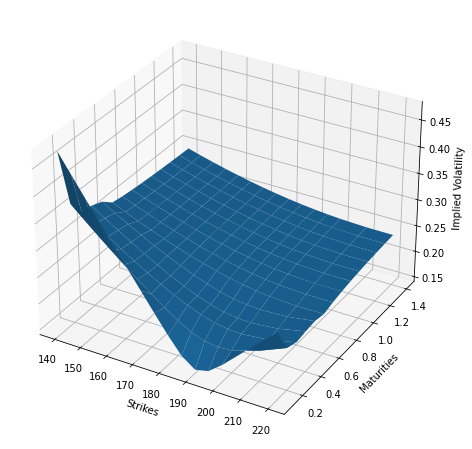

In [23]:
#SABR VOLATILITY SURFACE

volatility_surface = volatilitySurfaceSABR(method="normal", shift=0, beta=1, fwd=current_price)
SABRVolMatrix = volatility_surface["volMatrix"]

SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, SABRVolMatrix, day_count)
SABR_vol_surface.enableExtrapolation()

plot_vol_surface(vol_surface=SABR_vol_surface)

d = {'alpha': volatility_surface["a"], 'beta': volatility_surface["b"], 'nu': volatility_surface["n"], 'rho': volatility_surface["r"]}
pd.DataFrame(data=d, index=maturities)

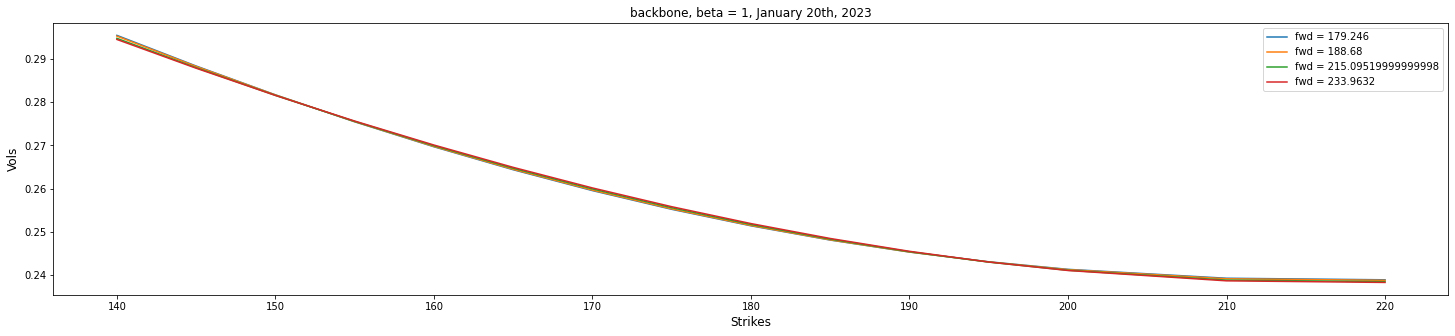

In [24]:
# Normal SABR Backbone modelling (Beta = 1)
beta = 1
fixes = (.95, 1, 1.14, 1.24)
tenor = dates[-1]
l = []
for i in fixes:
    vol_surface = volatilitySurfaceSABR(method="normal", shift=0, beta=beta, fwd=current_price * i)
    SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, vol_surface["volMatrix"], day_count)
    SABR_vol_surface.enableExtrapolation()

    l.append( ([SABR_vol_surface.blackVol(tenor, s) for s in strikes], "fwd = {}".format(current_price * i) ) )
    
plot_smile(tenor, l, market=False, title="backbone, beta = {}, {}".format(beta, tenor))

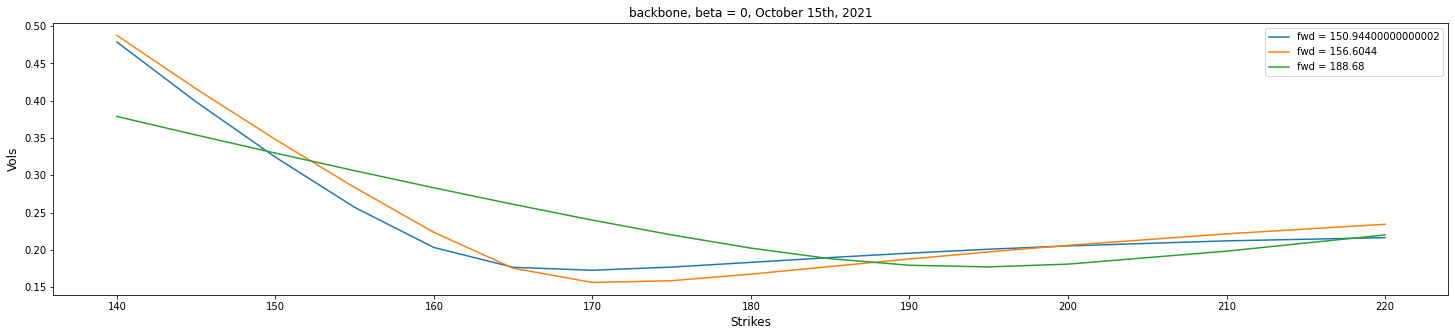

In [25]:
# Normal SABR Backbone modelling (Beta = 0)
beta = 0
fixes = (.8, .83, 1)
tenor = dates[2]
l = []
for i in fixes:
    vol_surface = volatilitySurfaceSABR(method="normal", shift=0, beta=beta, fwd=current_price * i)
    SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, vol_surface["volMatrix"], day_count)
    SABR_vol_surface.enableExtrapolation()

    sml = [SABR_vol_surface.blackVol(tenor, s) for s in strikes]
    l.append( (sml, "fwd = {}".format(current_price * i) ) )
    
plot_smile(tenor, l, market=False, title="backbone, beta = {}, {}".format(beta, tenor))

beta=1.0


,alpha,beta,nu,rho
0,0.136906,1.0,13.002911,-0.994987
1,0.136848,1.0,3.681509,-0.232243
2,0.169243,1.0,2.263193,-0.277232
3,0.195223,1.0,1.619780,-0.304001
4,0.197674,1.0,1.445803,-0.310927
5,0.195368,1.0,1.519624,-0.258073
6,0.220948,1.0,0.980765,-0.361758
7,0.237486,1.0,0.703659,-0.278507


beta=0.5


,alpha,beta,nu,rho
0,1.838202,0.5,12.193282,-0.994987
1,1.892423,0.5,3.600750,-0.188981
2,2.327762,0.5,2.191595,-0.221652
3,2.675160,0.5,1.551076,-0.233308
4,2.709766,0.5,1.375143,-0.234433
5,2.677493,0.5,1.457735,-0.182131
6,3.020639,0.5,0.899261,-0.256510
7,3.227650,0.5,0.645455,-0.106935


beta=0.0


,alpha,beta,nu,rho
0,24.657106,0.0,1.163634e+01,-0.994987
1,26.163564,0.0,3.533886e+00,-0.145811
2,32.047108,0.0,2.130549e+00,-0.164375
3,36.776868,0.0,1.491558e+00,-0.156829
4,44.612958,0.0,4.253688e-16,0.610804
5,45.356847,0.0,3.041803e-16,0.408981
6,463.346024,0.0,3.746374e+01,0.822661
7,82.057754,0.0,4.075866e+01,0.818208


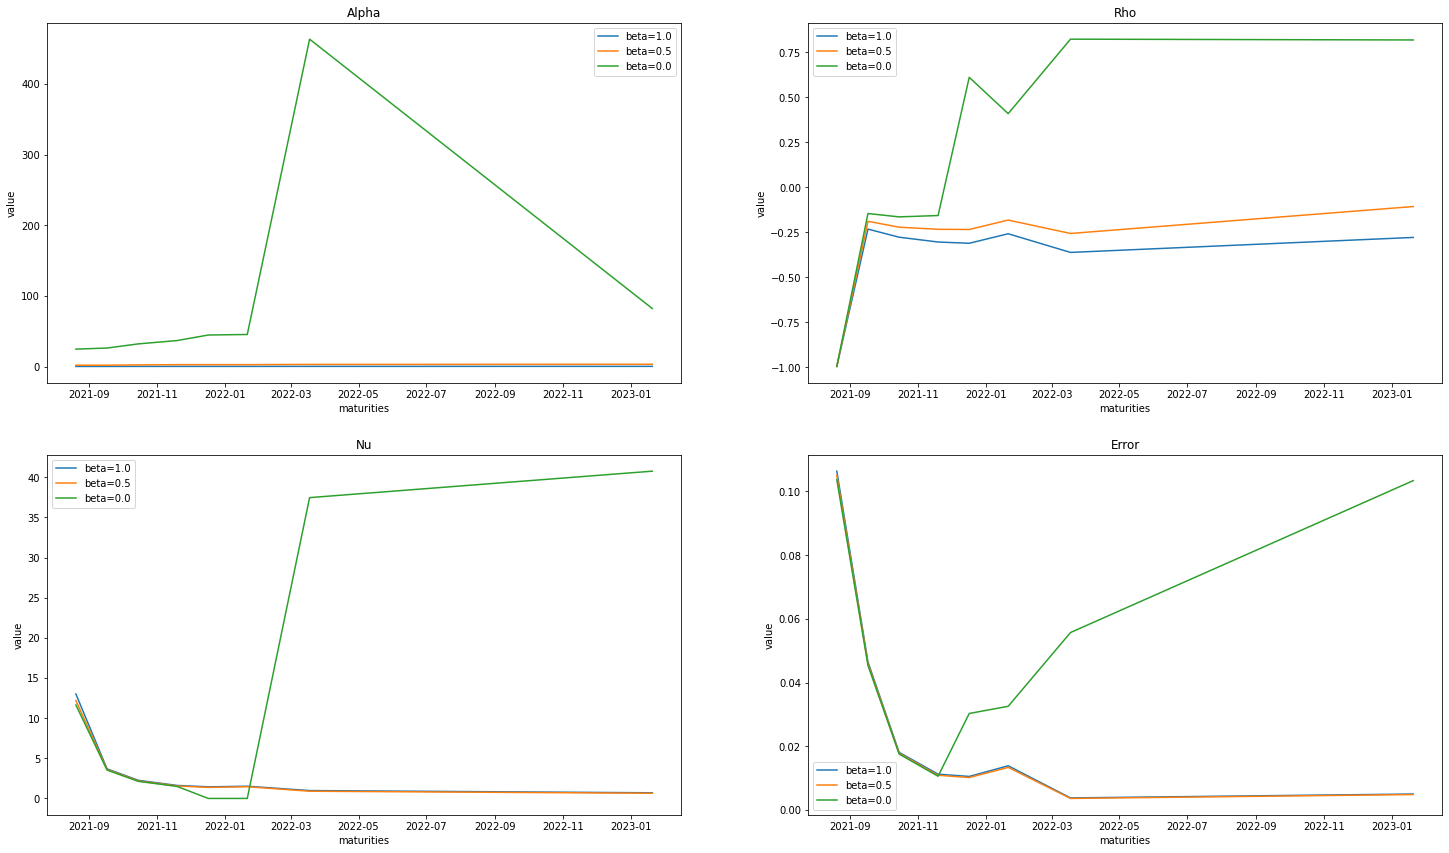

In [26]:
# Normal SABR Volatility model

normalSABR1 = volatilitySurfaceSABR(beta=1, shift=0)
normalSABR2 = volatilitySurfaceSABR(beta=.5, shift=0)
normalSABR3 = volatilitySurfaceSABR(beta=.0, shift=0)

normalSABR1_matrix = normalSABR1["volMatrix"]; normalSABR2_matrix = normalSABR2["volMatrix"]; normalSABR3_matrix = normalSABR3["volMatrix"]
normalSABR1_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, normalSABR1_matrix, day_count)
normalSABR2_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, normalSABR2_matrix, day_count)
normalSABR3_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, normalSABR3_matrix, day_count)
normalSABR1_surface.enableExtrapolation(); normalSABR2_surface.enableExtrapolation(); normalSABR3_surface.enableExtrapolation()

fig, axs = plt.subplots(2, 2, figsize=(25,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
for method in [normalSABR1, normalSABR2, normalSABR3]:
    lbl = "beta={}".format(method["b"][1])
    axs[0, 0].plot(maturities, method["a"], label=lbl)
    axs[0, 0].set_title('Alpha')
    axs[0, 0].set(xlabel='maturities', ylabel='value')
    axs[0, 0].legend()
    axs[1, 0].plot(maturities, method["n"], label=lbl)
    axs[1, 0].set_title('Nu')
    axs[1, 0].set(xlabel='maturities', ylabel='value')
    axs[1, 0].legend()
    axs[0, 1].plot(maturities, method["r"], label=lbl)
    axs[0, 1].set_title('Rho')
    axs[0, 1].set(xlabel='maturities', ylabel='value')
    axs[0, 1].legend()
    axs[1, 1].plot(maturities, method["e"], label=lbl)
    axs[1, 1].set_title('Error')
    axs[1, 1].set(xlabel='maturities', ylabel='value')
    axs[1, 1].legend()
    
    print(lbl)
    method_df = pd.DataFrame(
        data={'alpha': method["a"], 'beta': method["b"], 'nu': method["n"], 'rho': method["r"]})
    display(method_df)


beta=0.0


,alpha,beta,nu,rho
0,0.148323,1.0,14.925691,-0.994987
1,0.135652,1.0,3.851818,-0.236895
2,0.168159,1.0,2.376355,-0.279533
3,0.194183,1.0,1.707760,-0.304493
4,0.196585,1.0,1.524022,-0.312065
5,0.193791,1.0,1.598262,-0.259714
6,0.220013,1.0,1.037388,-0.361046
7,0.236444,1.0,0.738619,-0.282139


beta=0.0


,alpha,beta,nu,rho
0,1.989641,0.5,13.461784,-0.994647
1,1.922984,0.5,3.775485,-0.198686
2,2.371092,0.5,2.308815,-0.227708
3,2.730630,0.5,1.638435,-0.238669
4,2.759554,0.5,1.461552,-0.237575
5,2.722780,0.5,1.540027,-0.186646
6,3.085062,0.5,0.956934,-0.260870
7,3.294077,0.5,0.685187,-0.115730


beta=0.0


,alpha,beta,nu,rho
0,45.278989,0.0,2.150727e+01,-0.994987
1,27.253902,0.0,3.709428e+00,-0.155375
2,33.473178,0.0,2.248294e+00,-0.174091
3,38.492655,0.0,1.577297e+00,-0.167307
4,47.078596,0.0,3.476193e-17,0.360010
5,49.048923,0.0,3.586929e-05,0.617705
6,498.361224,0.0,3.819261e+01,0.822484
7,77.980096,0.0,3.828360e+01,0.818385


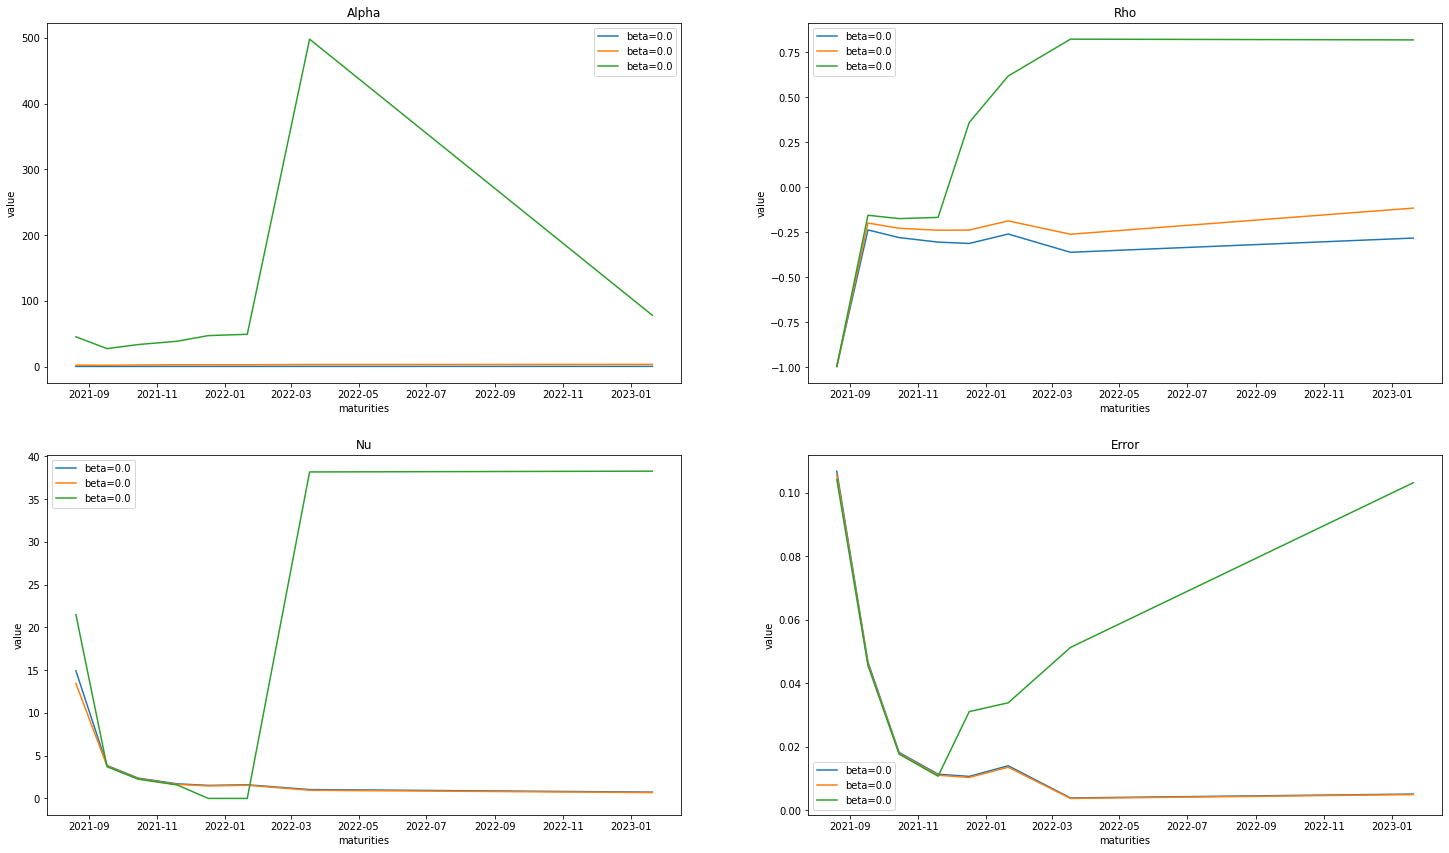

In [27]:
# Shifted SABR Volatility model

shiftedSABR1 = volatilitySurfaceSABR(beta=1, shift=10)
shiftedSABR2 = volatilitySurfaceSABR(beta=.5, shift=10)
shiftedSABR3 = volatilitySurfaceSABR(beta=.0, shift=10)

shiftedSABR1_matrix = shiftedSABR1["volMatrix"]; shiftedSABR2_matrix = shiftedSABR2["volMatrix"]; shiftedSABR3_matrix = shiftedSABR3["volMatrix"]
shiftedSABR1_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, shiftedSABR1_matrix, day_count)
shiftedSABR2_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, shiftedSABR2_matrix, day_count)
shiftedSABR3_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, shiftedSABR3_matrix, day_count)
shiftedSABR1_surface.enableExtrapolation(); shiftedSABR2_surface.enableExtrapolation(); shiftedSABR3_surface.enableExtrapolation()


fig, axs = plt.subplots(2, 2, figsize=(25,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
for method in [shiftedSABR1, shiftedSABR2, shiftedSABR3]:
    axs[0, 0].plot(maturities, method["a"], label=lbl)
    axs[0, 0].set_title('Alpha')
    axs[0, 0].set(xlabel='maturities', ylabel='value')
    axs[0, 0].legend()
    axs[1, 0].plot(maturities, method["n"], label=lbl)
    axs[1, 0].set_title('Nu')
    axs[1, 0].set(xlabel='maturities', ylabel='value')
    axs[1, 0].legend()
    axs[0, 1].plot(maturities, method["r"], label=lbl)
    axs[0, 1].set_title('Rho')
    axs[0, 1].set(xlabel='maturities', ylabel='value')
    axs[0, 1].legend()
    axs[1, 1].plot(maturities, method["e"], label=lbl)
    axs[1, 1].set_title('Error')
    axs[1, 1].set(xlabel='maturities', ylabel='value')
    axs[1, 1].legend()

    print(lbl)
    method_df = pd.DataFrame(
        data={'alpha': method["a"], 'beta': method["b"], 'nu': method["n"], 'rho': method["r"]})
    display(method_df)

beta=0.0


,alpha,beta,nu,rho
0,0.1,1.0,0.1,0.1
1,0.1,1.0,0.1,0.1
2,0.1,1.0,0.1,0.1
3,0.1,1.0,0.1,0.1
4,0.1,1.0,0.1,0.1
5,0.1,1.0,0.1,0.1
6,0.1,1.0,0.1,0.1
7,0.1,1.0,0.1,0.1


beta=0.0


,alpha,beta,nu,rho
0,2.075510,0.5,10.311065,-0.994987
1,1.812029,0.5,4.391007,-0.257297
2,2.295921,0.5,2.451860,-0.260793
3,2.656581,0.5,1.684197,-0.261686
4,2.696971,0.5,1.479231,-0.266956
5,2.629162,0.5,1.654403,-0.217553
6,3.009282,0.5,0.953349,-0.275529
7,3.207740,0.5,0.691129,-0.118958


beta=0.0


,alpha,beta,nu,rho
0,16.501255,0.1,10.062186,-0.994987
1,6.716125,0.1,15.378751,0.086618
2,7.547098,0.1,12.525452,0.070491
3,8.296993,0.1,10.297894,0.053843
4,8.369329,0.1,9.057595,0.052034
5,8.693253,0.1,7.695534,0.040667
6,24.453989,0.1,0.888432,-0.167683
7,26.085633,0.1,0.654565,0.056607


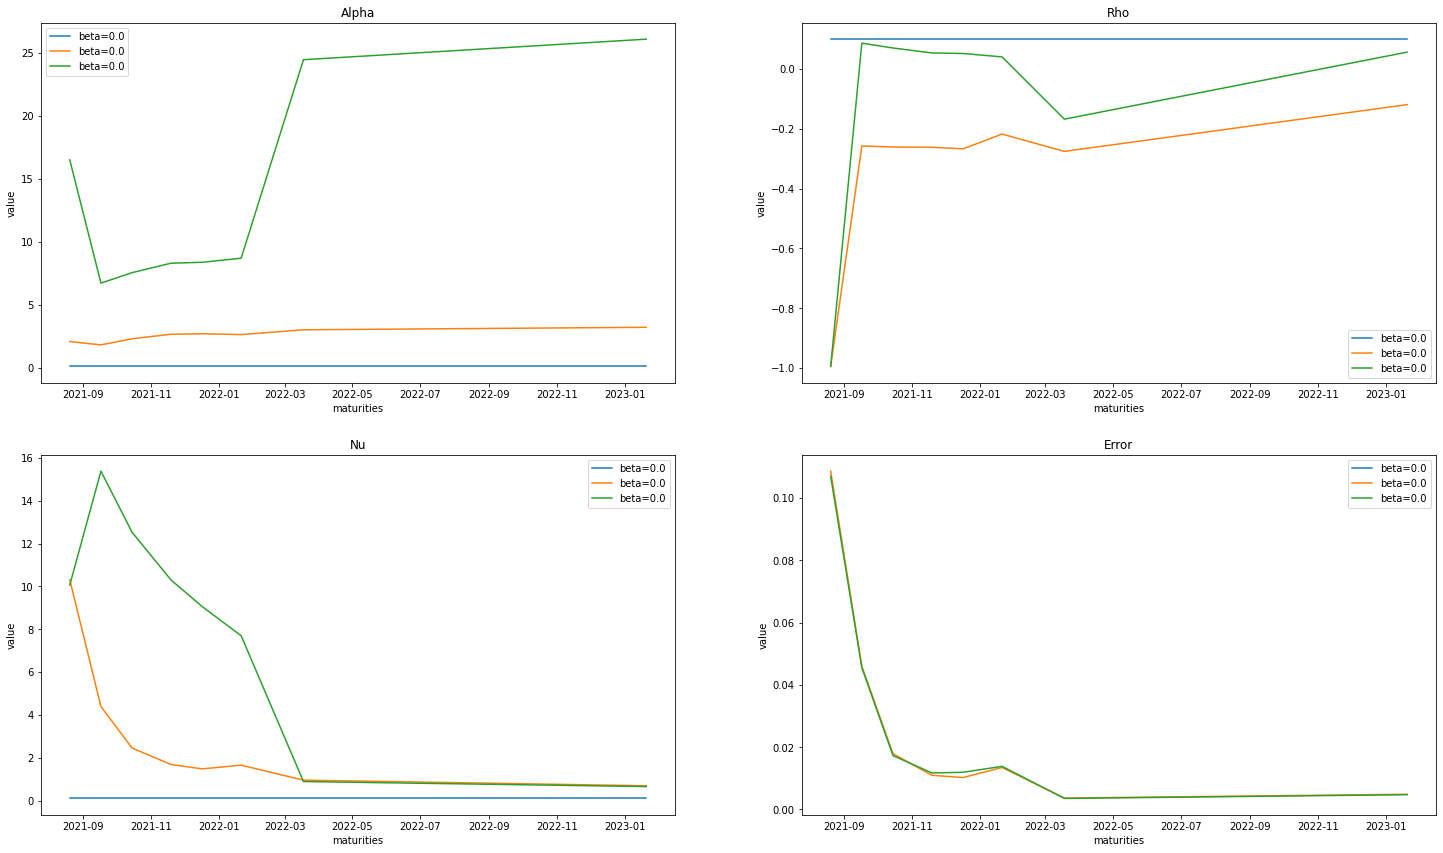

In [28]:
# Floch-Kennedy SABR Volatility model

floch_kennedy1 = volatilitySurfaceSABR(beta=1, shift=0, method="floch-kennedy")
floch_kennedy2 = volatilitySurfaceSABR(beta=.5, shift=0, method="floch-kennedy")
floch_kennedy3 = volatilitySurfaceSABR(beta=.1, shift=0, method="floch-kennedy")

floch_kennedy1_matrix = floch_kennedy1["volMatrix"]; floch_kennedy2_matrix = floch_kennedy2["volMatrix"]; floch_kennedy3_matrix = floch_kennedy3["volMatrix"]
floch_kennedy1_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, floch_kennedy1_matrix, day_count)
floch_kennedy2_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, floch_kennedy2_matrix, day_count)
floch_kennedy3_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, floch_kennedy3_matrix, day_count)
floch_kennedy1_surface.enableExtrapolation(); floch_kennedy2_surface.enableExtrapolation(); floch_kennedy3_surface.enableExtrapolation()

fig, axs = plt.subplots(2, 2, figsize=(25,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
for method in [floch_kennedy1, floch_kennedy2, floch_kennedy3]:
    axs[0, 0].plot(maturities, method["a"], label=lbl)
    axs[0, 0].set_title('Alpha')
    axs[0, 0].set(xlabel='maturities', ylabel='value')
    axs[0, 0].legend()
    axs[1, 0].plot(maturities, method["n"], label=lbl)
    axs[1, 0].set_title('Nu')
    axs[1, 0].set(xlabel='maturities', ylabel='value')
    axs[1, 0].legend()
    axs[0, 1].plot(maturities, method["r"], label=lbl)
    axs[0, 1].set_title('Rho')
    axs[0, 1].set(xlabel='maturities', ylabel='value')
    axs[0, 1].legend()
    axs[1, 1].plot(maturities, method["e"], label=lbl)
    axs[1, 1].set_title('Error')
    axs[1, 1].set(xlabel='maturities', ylabel='value')
    axs[1, 1].legend()

    print(lbl)
    method_df = pd.DataFrame(
        data={'alpha': method["a"], 'beta': method["b"], 'nu': method["n"], 'rho': method["r"]})
    display(method_df)

C:\Users\somig\AppData\Local\Temp/ipykernel_3164/1485649620.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


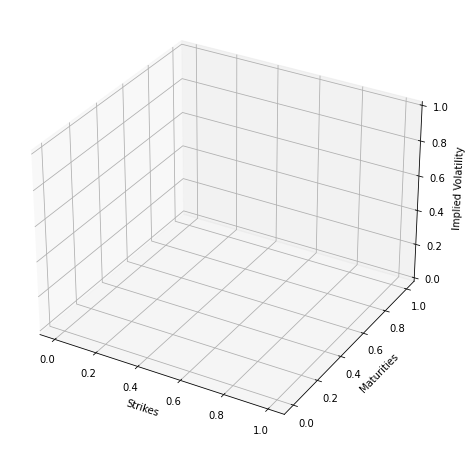

In [29]:
#DUPIRE LOCAL VOLATILITY SURFACE (NOT PLOTTABLE)

black_var_surface.setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)
#if does not work use NoExceptLocalVolSurface
local_vol_surface = ql.LocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote)

# Plot the Dupire surface ...
local_vol_surface.enableExtrapolation()
plot_vol_surface(local_vol_surface, plot_years=np.arange(0.1, .657, 0.1), plot_strikes=strikes[60:], funct='localVol')


C:\Users\somig\AppData\Local\Temp/ipykernel_3164/1485649620.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


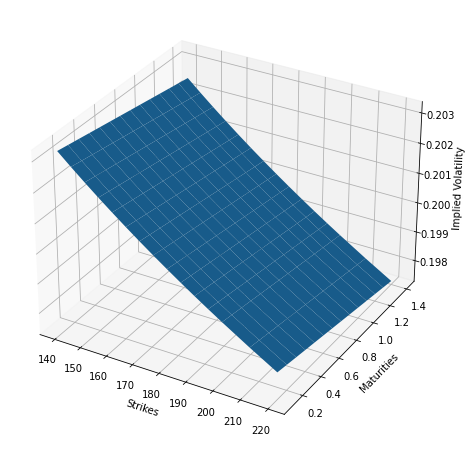

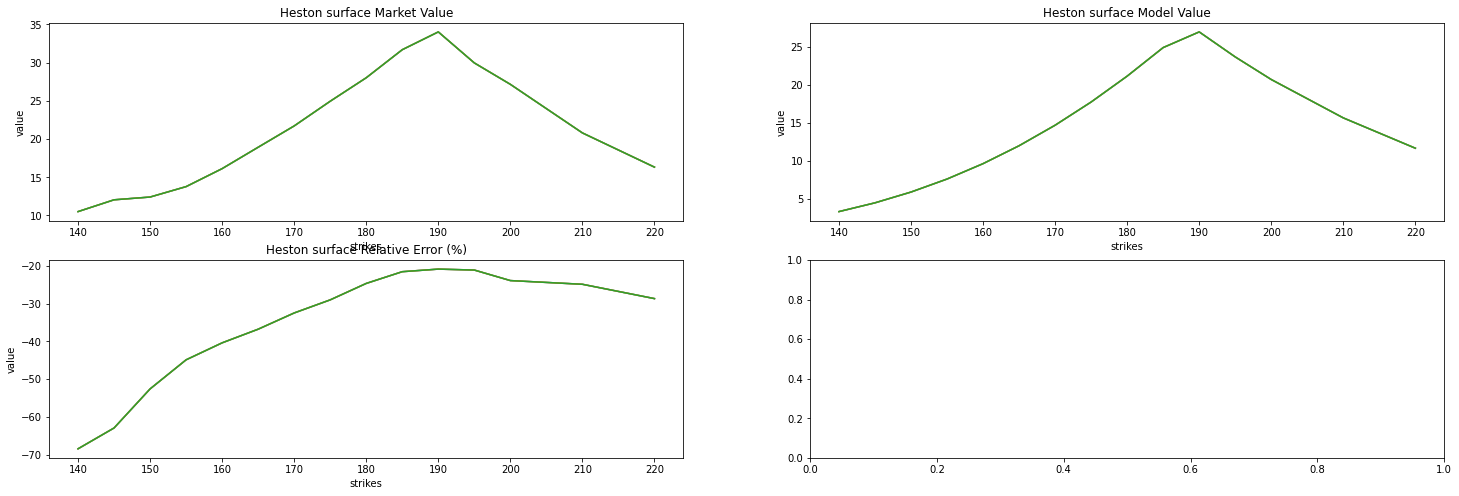

In [30]:
#HESTON MODEL SURFACE PLOTTING (Levenberg-Marquardt Method)

# dummy parameters
v0, kappa, theta, rho, sigma = (0.04, 0.01, 0.01, -0.9, .01)

process = ql.HestonProcess(flat_ts, dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(current_price)), 
                           v0, kappa, theta, sigma, rho)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model) 

heston_helpers = []
black_var_surface.setInterpolation("bicubic")
one_year_idx = -1 
date = dates[one_year_idx]

for j, s in enumerate(strikes):
    t = (date - today)
    p = ql.Period(t, ql.Days)
    sigma = vols[one_year_idx][j] 

    helper = ql.HestonModelHelper(p, calendar, current_price, s, 
                                  ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                  flat_ts, 
                                  dividend_ts)
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model.calibrate(heston_helpers, lm, 
                 ql.EndCriteria(5000, 500, 1.0e-8, 1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model.params()

# Boilerplate to get to the Vol Surface object
heston_model = ql.HestonModel(process)
heston_handle = ql.HestonModelHandle(heston_model)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

# Plot the vol surface ...
plot_vol_surface(heston_vol_surface)


# Statistical analysis on the Heston model and plotting

strks, marketValue, modelValue, relativeError = ([], [], [], [])

avgError = 0
for i, opt in enumerate(heston_helpers):
    err = (opt.modelValue()/opt.marketValue() - 1.0)
    strks.append(strikes[i]); marketValue.append(opt.marketValue()); modelValue.append(opt.modelValue()); relativeError.append(100.0*(opt.modelValue()/opt.marketValue() - 1.0))
    avgError += abs(err)
avgError = avgError*100.0/len(heston_helpers)

market_errors = pd.DataFrame({"Strikes": strks, "Market Value": marketValue, "Model Value": modelValue, "Relative Error (%)": relativeError})

fig, axs = plt.subplots(2, 2, figsize=(25,8))
for column in market_errors.columns.tolist()[1:]:
    axs[0, 0].plot(strks, marketValue)
    axs[0, 0].set_title('Heston surface Market Value')
    axs[0, 0].set(xlabel='strikes', ylabel='value')
    axs[0, 1].plot(strks, modelValue)
    axs[0, 1].set_title('Heston surface Model Value')
    axs[0, 1].set(xlabel='strikes', ylabel='value')
    axs[1, 0].plot(strks, relativeError)
    axs[1, 0].set_title('Heston surface Relative Error (%)')
    axs[1, 0].set(xlabel='strikes', ylabel='value')


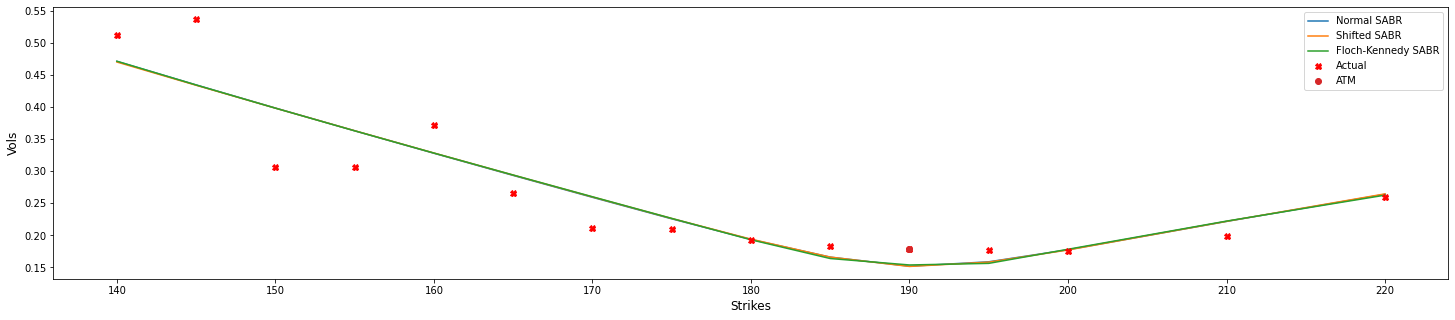

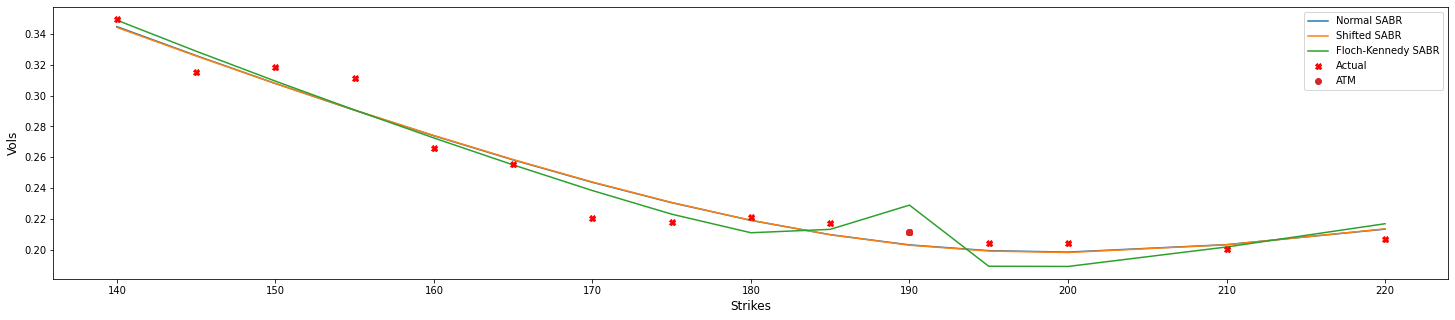

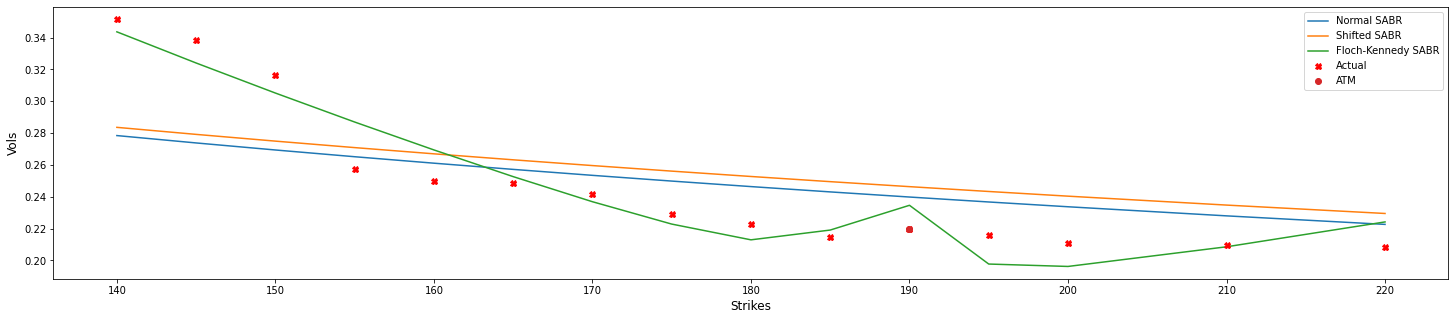

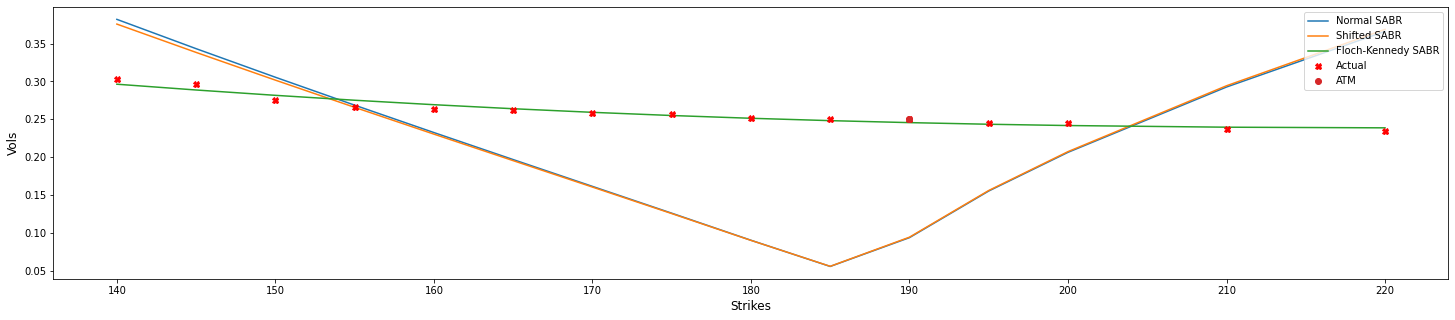

In [31]:
# BACKBONE PLOTTING
for i in [1, 3, 5, 7]:
        tenor = dates[i]
        lis = [
                ([normalSABR3_surface.blackVol(tenor, s) for s in strikes], "Normal SABR" ),
                ([shiftedSABR3_surface.blackVol(tenor, s) for s in strikes], "Shifted SABR" ),
                ([floch_kennedy3_surface.blackVol(tenor, s) for s in strikes], "Floch-Kennedy SABR" ),
                # ([heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston" ),
                ]
        plot_smile(tenor, lis)

C:\Users\somig\AppData\Local\Temp/ipykernel_3164/1485649620.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


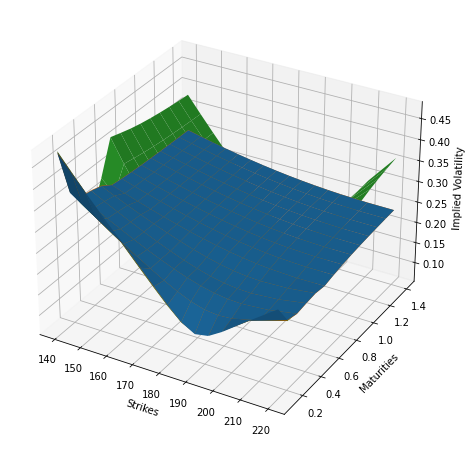

In [32]:
plot_vol_surface([ normalSABR1_surface, normalSABR2_surface, normalSABR3_surface])